##Entropy view

This notebook can be used to compare the change in the internal state between two prompts

In [12]:
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from generate_entropys import calculate_attention_entropy, get_df, get_attention
from transformers import AutoModelForCausalLM, AutoTokenizer
from figures import create_heat_map_for_df,create_heat_map_for_tensor,create_hist_for_df,create_hist_for_tensor
from utils import print_cuda_info

layer_start = 0
layer_end = None

task = "Is this true? Only yes or no!"
a_prompt = task + "George Washington was the first president of the USA."
b_prompt = task + "Issaac Asimov wrote a book called Daybreak."

model_id = 'google/gemma-2-27b-it'

xlim = None (0,1)
ylim = None #(0, 2000)

os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"
print_cuda_info()

<>:21: SyntaxWarning: 'NoneType' object is not callable; perhaps you missed a comma?
<>:21: SyntaxWarning: 'NoneType' object is not callable; perhaps you missed a comma?
/tmp/ipykernel_452317/1978906412.py:21: SyntaxWarning: 'NoneType' object is not callable; perhaps you missed a comma?
  xlim = None (0,1)
/tmp/ipykernel_452317/1978906412.py:21: SyntaxWarning: 'NoneType' object is not callable; perhaps you missed a comma?
  xlim = None (0,1)
/tmp/ipykernel_452317/1978906412.py:21: SyntaxWarning: 'NoneType' object is not callable; perhaps you missed a comma?
  xlim = None (0,1)


TypeError: 'NoneType' object is not callable

In [2]:
#init model compontens
tokenizer = AutoTokenizer.from_pretrained(model_id,device_map="auto")
model = AutoModelForCausalLM.from_pretrained(model_id, output_attentions=True,device_map="auto")
print(model.device)

Loading checkpoint shards: 100%|██████████| 12/12 [00:29<00:00,  2.48s/it]


cuda:0


In [3]:
#get internal state 
a_attention, a_decoded_text = get_attention(prompt=a_prompt,model=model,tokenizer=tokenizer)
b_attention, b_decoded_text = get_attention(prompt=b_prompt,model=model,tokenizer=tokenizer)

In [4]:
print(a_attention.shape)

torch.Size([46, 1, 32, 20, 20])


In [5]:
def caculate_entropy(attention):
    return -torch.sum(attention * torch.log(attention + 1e-9), dim=-1) / torch.log(torch.tensor(attention.shape[-1]))

def calculate_mean(attention):
    return torch.mean(attention,dim=-1)

def calculate_std(attention):
    return torch.std(attention,dim=-1)

In [6]:
#preprocess
a_attention = a_attention.cpu()
b_attention = b_attention.cpu()


#layer selection
a_attention = a_attention[layer_start:layer_end] 
b_attention = b_attention[layer_start:layer_end]

#token selection
#a_attention = a_attention[:,:,:,-1]
#b_attention = b_attention[:,:,:,-1]

In [7]:
a_entropy = calculate_mean(a_attention)
b_entropy = calculate_mean(b_attention)

In [8]:
#answers
print(a_decoded_text)
print(b_decoded_text)

<bos>Is this true? Only yes or no!George Washington was the first president of the USA.

Answer: Yes.<end_of_turn>
<eos>
<bos>Is this true? Only yes or no!Issaac Asimov wrote a book called Daybreak.

Yes.<end_of_turn>
<eos>


In [9]:
#statistics
a_values = np.concatenate([tensor.numpy().flatten() for tensor in a_entropy])
b_values = np.concatenate([tensor.numpy().flatten() for tensor in b_entropy])

print("mean original_values",a_values.mean())
print("mean transformed_values",b_values.mean())

mean original_values 0.05
mean transformed_values 0.045454554


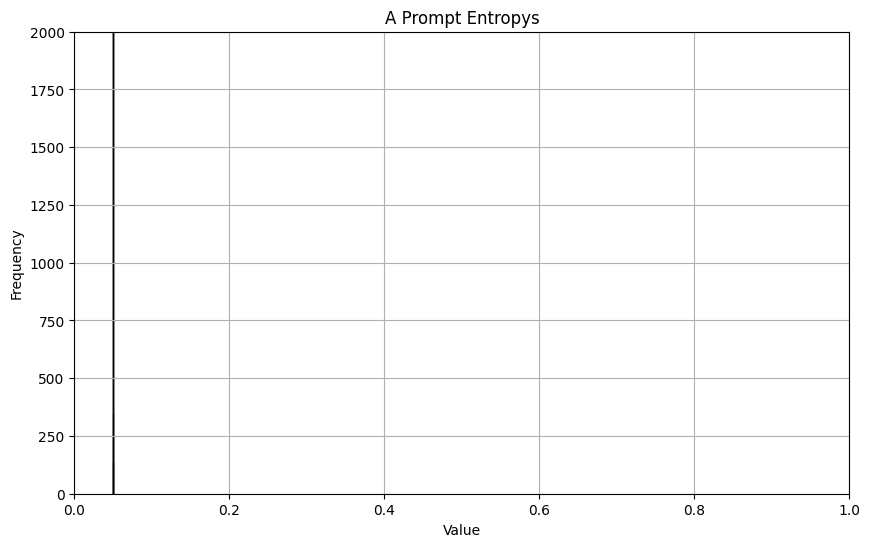

<Figure size 640x480 with 0 Axes>

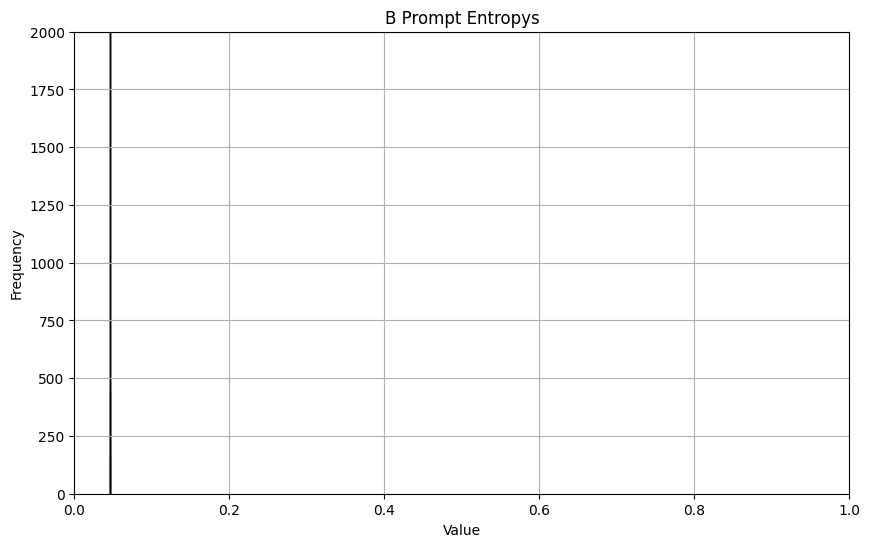

<Figure size 640x480 with 0 Axes>

In [13]:

title = 'A Prompt Entropys'
create_hist_for_tensor(a_entropy,title=title,xlim=xlim,ylim=ylim)
title = 'B Prompt Entropys'
create_hist_for_tensor(b_entropy,title=title,xlim=xlim,ylim=ylim)

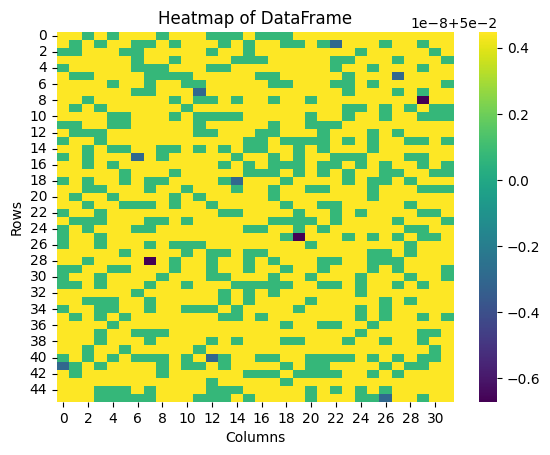

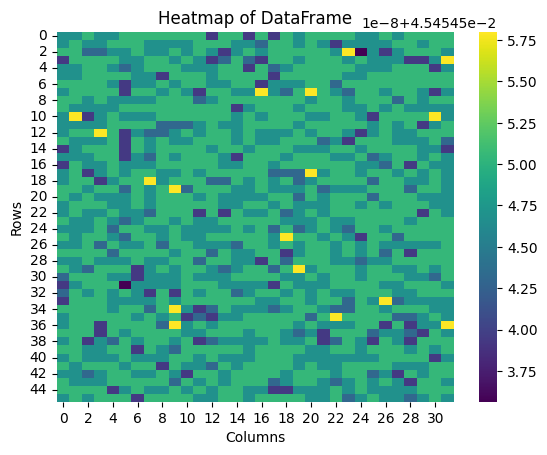

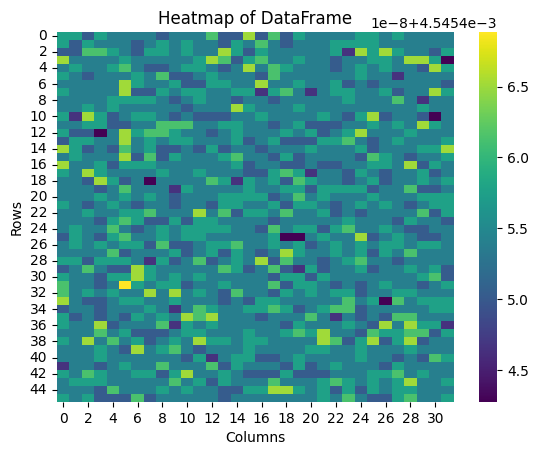

In [11]:
a_avg_token_entropy = torch.squeeze(torch.mean(a_entropy,dim=-1))
b_avg_token_entropy = torch.squeeze(torch.mean(b_entropy,dim=-1))
create_heat_map_for_tensor(a_avg_token_entropy)
create_heat_map_for_tensor(b_avg_token_entropy)

distance_tensor = a_avg_token_entropy - b_avg_token_entropy 
distance_tensor = distance_tensor.abs()
create_heat_map_for_tensor(distance_tensor)